In [1]:
import torch
import pickle
import numpy as np
from time import time as T
from bindsnet.network import Network
from bindsnet.network.nodes import RealInput, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.learning import Hebbian
from IPython.display import clear_output

In [2]:
import matplotlib.pyplot as plt

In [3]:
def moving_average(a, n=100):
    moving_average = []
    for i in range(len(a)):
        start = max(0, i - n)
        values = a[start:i+1]
        moving_average.append(np.sum(values) / float(len(values)))
    return np.array(moving_average)

In [4]:
class Encoder():
    def __init__(self, e_size=25):
        self.encodings = {}
        self.e_size = e_size

    def encode(self, x):
        if x in self.encodings:
            return self.encodings[x]
        self.encodings[x] = torch.rand(e_size)
        return self.encodings[x]

    def decode(self, v):
        nearest = None
        best = float('inf')
        for x, e in self.encodings.items():
            dist = (torch.sum((v - e).pow(2))).pow(0.5)
            if dist < best:
                best = dist
                nearest = x
        return nearest
    
    def precode(self, stream):
        for i in stream:
            self.encode(i)

In [5]:
class KNNClassifier:
    def __init__(self, k=1):
        self.k = k
        self.data = []
    def add_sample(self, sample, label):
        self.data.append((sample, label))
    def classify(self, new_sample):
        distances = [(None, float('inf'))]*self.k
        for sample, label in self.data:
            dist = torch.sum(torch.abs(new_sample-sample))
            for i, (_, best_dist) in enumerate(distances):
                if dist < best_dist:
                    distances[i] = (label, dist)
                    break
        counts = {}
        for p_label, _ in distances:
            if p_label not in counts:
                counts[p_label] = 0
            counts[p_label] += 1
        counts = list(counts.items())
        counts.sort(key=lambda x: x[1])
        return counts[0][0]

In [6]:
class Prototype(Network):
    def __init__(self, encoder, dt: float = 1.0, lag: int = 10, n_neurons: int = 100, time: int = 100):
        super().__init__(dt=dt)
        self.n_neurons = n_neurons
        self.lag = lag
        self.encoder = encoder
        self.time = time
        
        for i in range(lag):
            self.add_layer(RealInput(n=encoder.e_size, traces=True), name=f'input_{i+1}')
            self.add_layer(LIFNodes(n=self.n_neurons, traces=True), name=f'column_{i+1}')
            self.add_monitor(Monitor(self.layers[f'column_{i+1}'], ['s'], time=self.time), name=f'monitor_{i+1}')
            w = 0.3 * torch.rand(self.encoder.e_size, self.n_neurons)
            self.add_connection(Connection(source=self.layers[f'input_{i+1}'], target=self.layers[f'column_{i+1}'], update_rule=Hebbian, w=w), source=f'input_{i+1}', target=f'column_{i+1}')
        
        for i in range(lag):
            for j in range(lag):
                w = -0.2 * torch.rand(self.n_neurons, self.n_neurons)
                self.add_connection(Connection(source=self.layers[f'column_{i+1}'], target=self.layers[f'column_{j+1}'], w=w), source=f'column_{i+1}', target=f'column_{j+1}')      
                
                
    def run(self, inpts, **kwargs) -> None:
        inpts = {k:self.encoder.encode(v).repeat(self.time, 1) for k, v in inpts.items()}
        super().run(inpts, self.time, **kwargs)


In [7]:
e_size = 25
lag = 10
n_neurons = 100
runtime = 100

In [8]:
stream = pickle.load(open('dataset.pkl', 'rb'))['noisy']
encoder = Encoder(e_size)
encoder.precode([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

net = Prototype(encoder, lag=lag, time=runtime, n_neurons=n_neurons)
classifier = KNNClassifier()

plot = False
correct = []
stimes = []
ctimes = []
for cur in range(10,35):
    inpt = {f'input_{i+1}': stream[cur+i-10] for i in range(lag)}
    target = stream[cur]
    
    start = T()
    
    net.reset_()
    net.run(inpt)
    
    stimes.append(T()-start)
    
    start = T()    
    
    readout = torch.zeros(lag, runtime*n_neurons)
    for i in range(lag):
        readout[i] = net.monitors[f'monitor_{i+1}'].get('s').view(-1)
    prediction = classifier.classify(readout)
    
    if stream[cur+1] >= 10:
        correct.append(int(prediction == target))
        print(prediction, target)
        print(moving_average(correct)[-1])
        clear_output(wait=True)
        
    classifier.add_sample(readout, target)
    
    ctimes.append(T()-start)
        
    if plot:
        plt.figure(figsize=(25, 10))
        plt.suptitle(f'Target: {target}')
        for i in range(lag):
            plt.subplot(2, lag//2, i+1)
            plt.title(f'Column {i+1} Spikes for {stream[cur+i-9]}')
            plt.imshow(net.monitors[f'monitor_{i+1}'].get('s'))
            plt.pause(1e-5)

19475 5
0.0


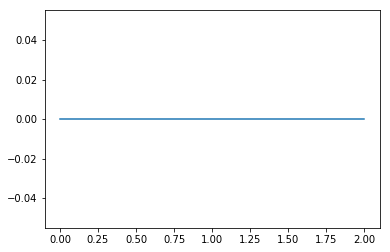

In [9]:
plt.plot(moving_average(correct))

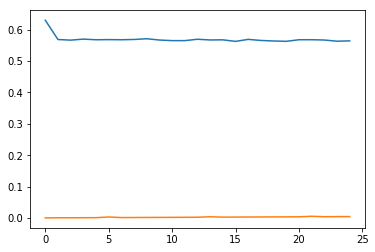

In [10]:
plt.plot(stimes)
plt.plot(ctimes)

In [11]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    _seen_ids = set()
    def inner(obj):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

In [12]:
getsize(classifier)

7067